<div class="alert alert-block alert-info">
<b>IMPORTS</b>
</div>

In [1]:
#Code to connect your google drive with google colaboratory
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<div class="alert alert-block alert-info">
<b>Code Citation</b>
</div>

In [ ]:
# Only the Bag of visual words code has been taken and modifed with.
# https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f

In [5]:
# Packages
import numpy as np
import cv2 as cv
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
import time
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from fastai.vision import *
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, f1_score
!pip install --upgrade fastai

In [16]:
# Defining the path
path = '/content/drive/MyDrive/Assignment/Images'

# Files and reading the data
digits_image = os.path.join(path, 'digits.png')
digit_image = cv.imread(digits_image, cv.IMREAD_GRAYSCALE)

# Printing the digit name
print("The image file name is:", os.path.basename(digits_image))
print(f"The shape of the image is {digit_image.shape}")

# Training and Test Paths
training_folder_path = os.path.join(path, "Train")
testing_folder_path = os.path.join(path, "Test")

# Create Train and Test folders if they don't exist
if os.path.isfile(training_folder_path) and os.path.isfile(training_folder_path) == False:
    os.mkdir(training_folder_path)
    os.mkdir(testing_folder_path)


The image file name is: digits.png
The shape of the image is (1000, 2000)


In [9]:
# Create Arrays of 20 by 20 patch
all_digit_numbers = np.empty((0,20,20),dtype=np.uint8)
training_digits = np.empty((0,20,20),dtype=np.uint8)
test_digits = np.empty((0,20,20),dtype=np.uint8)

# Format
training_images, testing_images = [],[]

# LOCATE DIGITS
# 10 DIGITS
for k in range(10):
  # 5 ROWS
    for r in range(5):
      # 100 NUMBERS
        for i in range(100):
          # IMAGE SLICING
            digit = digit_image[(k*5+r)*20:(k*5+r+1)*20, i*20:(i+1)*20]
            #  Adding another dimension due to the array's initial size
            digit = np.expand_dims(digit, axis=0)
            # ADD TO THE BIG ARRAY
            all_digit_numbers = np.append(all_digit_numbers, digit, axis=0) # Just in case we need to the full size
            if r < 4:
                # Appending 80%
                training_digits = np.append(training_digits, digit, axis=0)# Append 4 rows for training
            else:
                # Appending 20%
                test_digits = np.append(test_digits, digit, axis=0)  # Append the last row for testing

training_elements, testing_elements = 0,0

for i in range(10): # 0-9 digits
    counter = 1
    for j in range(4): # 4 rows
        for k in range(100):
            # row1 = 0-100 # row2 = 100-200 # row3 = 200-300# row4 = 300-400
            filename = f"digit_{i}_row{j+1}_id_{counter}.jpg"
            # 0-3999 == 4000 elements which is 80 percent for training
            image = os.path.join(training_folder_path, filename)
            # If image does not exists, then create it
            if os.path.isfile(image) == False:
                cv.imwrite(image, np.uint8(training_digits[training_elements])) # Saving the image in the Train folder 0 till 4000
            # APPEND TO TRAINING ARRAY
            training_images.append(np.uint8(training_digits[training_elements]))
            counter += 1
            training_elements += 1 # till 4000 elements

    counter = 1
    for l in range(100): # There's only 1000 elements for testing
        filename = f"digit_{i}_id_{counter}.jpg"
        testing_folder_path_1 = os.path.join(testing_folder_path, filename)
        # If image does not exists, then create it
        if os.path.isfile(testing_folder_path_1) == False:
            cv.imwrite(testing_folder_path_1, np.uint8(test_digits[testing_elements])) # Saving the image in the Test folder 0 till 2000
        # APPEND TO TESTING ARRAY
        testing_images.append(np.uint8(test_digits[testing_elements]))
        counter += 1
        testing_elements += 1

# all_digit_numbers.shape #Confirming we have (5000, 20, 20)
print(all_digit_numbers.shape)
print(training_digits.shape)
print(test_digits.shape)

# At the moment the images are 20 x 20
# Convert it to a row vector of 400
train_array = np.array(training_images).reshape(-1,400).astype(np.float32)
test_array = np.array(testing_images).reshape(-1,400).astype(np.float32)

print(f"The size of the training array is: {train_array.shape}")
print(f"The size of the testing array is: {test_array.shape}")

(5000, 20, 20)
(4000, 20, 20)
(1000, 20, 20)
The size of the training array is: (4000, 400)
The size of the testing array is: (1000, 400)


<div class="alert alert-block alert-info">
<b>Support Vector Machine:</b> One-VS-Rest for Multi-class classification
</div>

The accuracy for the class 0 vs the rest is: 99.2% with an error rate of 0.80%
The accuracy for the class 1 vs the rest is: 99.7% with an error rate of 0.30%
The accuracy for the class 2 vs the rest is: 96.6% with an error rate of 3.40%
The accuracy for the class 3 vs the rest is: 97.5% with an error rate of 2.50%
The accuracy for the class 4 vs the rest is: 98.0% with an error rate of 2.00%
The accuracy for the class 5 vs the rest is: 96.4% with an error rate of 3.60%
The accuracy for the class 6 vs the rest is: 98.5% with an error rate of 1.50%
The accuracy for the class 7 vs the rest is: 98.4% with an error rate of 1.60%
The accuracy for the class 8 vs the rest is: 95.8% with an error rate of 4.20%
The accuracy for the class 9 vs the rest is: 97.0% with an error rate of 3.00%

The highest One-Vs-Rest accuracy was 99.7% for class 1 with an average accuracy of 97.71.


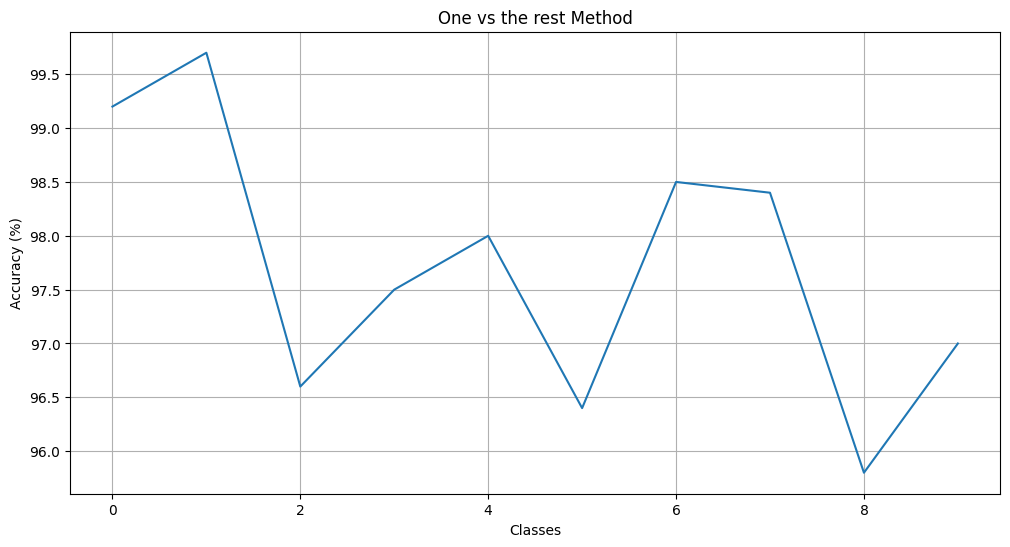

In [12]:
# Support Vector Machine
# Transform type from int to float for data consistency
# create an array from 0-9
c = np.arange(10)
classes = 10

# 400 because each digit has 400 variants so 0-9 digits are balanced with 4000 samples
train_labels = np.repeat(c,400)[:,np.newaxis]

# 100 is the same as above but for 10 digits with 1000 samples
test_labels = np.repeat(c,100)[:,np.newaxis]

train_labels, test_labels = np.float32(train_labels), np.float32(test_labels)

average = 0
svm_models, accuracy_list, predictions = [], [], []
for i in range(classes):
    # One-versus-the-rest method
    # This is a binary problem since SVM does not support multi-class classification
    # initially they are lists for simplicity sake
    binary_train_labels = [1 if label == i else -1 for label in train_labels]
    binary_test_labels = [1 if label == i else -1 for label in test_labels]

    # Convert the lists to arrays for futher analysis and use
    binary_train_labels, binary_test_labels  = np.array(binary_train_labels), np.array(binary_test_labels)

    # INITIALISE SVM MODEL
    svm = cv.ml.SVM_create()
    svm.setType(cv.ml.SVM_C_SVC)
    svm.setKernel(cv.ml.SVM_LINEAR)
    svm.setC(0.000001)  # Set the cost parameter to 0.1
    svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 1000, 1e-8))
    svm.train(train_array, cv.ml.ROW_SAMPLE, binary_train_labels)

    # PREDICTIONS
    response_test = svm.predict(test_array)
    outcome_test = (response_test[1]) # keep them as float32

    # outcome_test will be a column vector so we will need to match its form to binary_test_labels
    prediction = outcome_test.flatten()
    matches_test = prediction == binary_test_labels
    correct_test = np.count_nonzero(matches_test)
    accuracy_test = (correct_test * 100.0) / (outcome_test.size)
    error_rate = 100 - accuracy_test
    svm_models.append(svm)
    accuracy_list.append(accuracy_test)
    predictions.append(prediction)
    average += accuracy_test

    # PRINTING RESULTS
    print(f"The accuracy for the class {i} vs the rest is: {accuracy_test}% with an error rate of {error_rate:.2f}%")

# FINDING HIGHEST CLASS-BASED ACCURACY
greater_var = -math.inf
for i, accuracy in enumerate(accuracy_list):
    if accuracy > greater_var:
        CLASS = i
        greater_var = accuracy
print(f"\nThe highest One-Vs-Rest accuracy was {greater_var}% for class {CLASS} with an average accuracy of {average/10:.2f}.")

# PLOT GRAPH CLASS AND ACCURACY
num_classes = [0,1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(12,6))
plt.plot(num_classes, accuracy_list)
plt.xlabel("Classes")
plt.ylabel("Accuracy (%)")
plt.title("One vs the rest Method")
plt.grid(True)
plt.axis('on')
plt.show()


<div class="alert alert-block alert-info">
<b>Support Vector Machine:</b> Confusion Matrices & Classification Metrics Evaluation
</div>

There are 1000 samples being tested

SVM METRICS
 +-------+----+----+----+-----+----------------------+-----------+--------+----------+------------+
| CLASS | TP | FN | FP |  TN | One_vs_Rest_accuracy | PRECISION | RECALL | F1 SCORE | ERROR_RATE |
+-------+----+----+----+-----+----------------------+-----------+--------+----------+------------+
|   0   | 95 | 5  | 3  | 897 |        99.20%        |   0.969   |  0.95  |  0.959   |   0.80%    |
|   1   | 98 | 2  | 1  | 899 |        99.70%        |    0.99   |  0.98  |  0.985   |   0.30%    |
|   2   | 74 | 26 | 8  | 892 |        96.60%        |   0.902   |  0.74  |  0.813   |   3.40%    |
|   3   | 80 | 20 | 5  | 895 |        97.50%        |   0.941   |  0.8   |  0.865   |   2.50%    |
|   4   | 88 | 12 | 8  | 892 |        98.00%        |   0.917   |  0.88  |  0.898   |   2.00%    |
|   5   | 67 | 33 | 3  | 897 |        96.40%        |   0.957   |  0.67  |  0.788   |   3.60%    |
|   6   | 90 | 10 | 5  | 895 |        98.50%        |   0.9

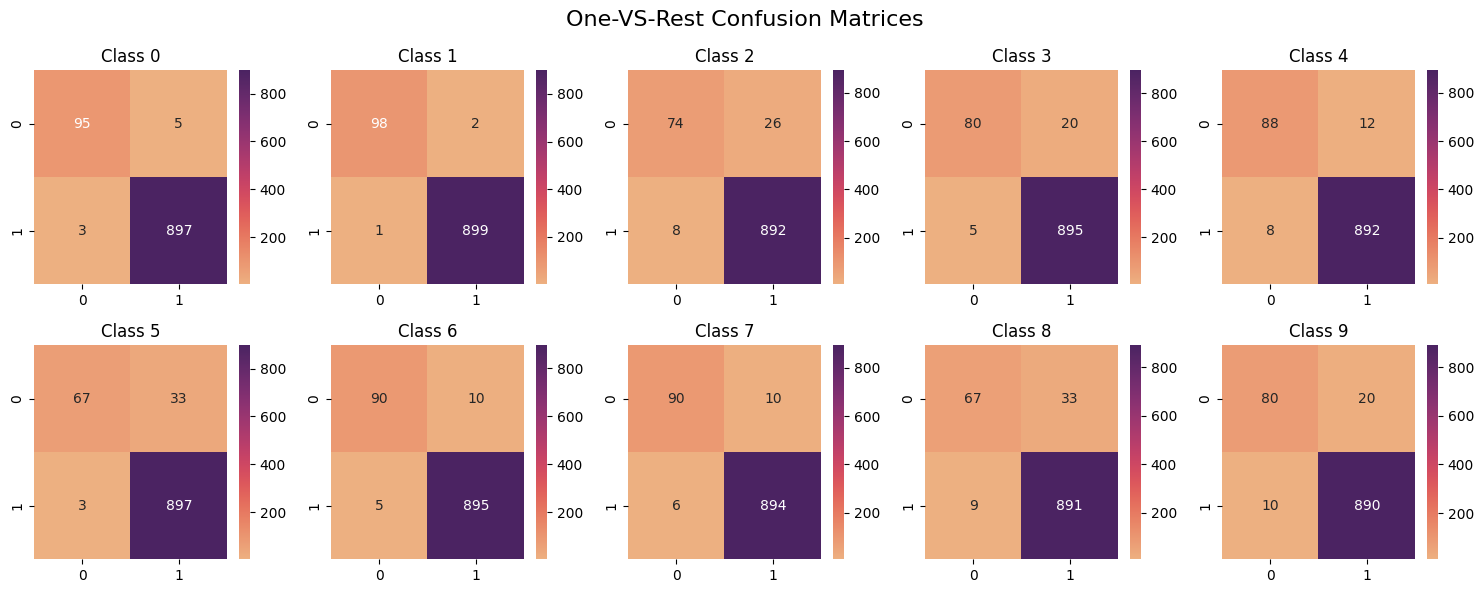

In [14]:


# START COMMENTING FROM HERE


# INITIALISE TABLE
table = PrettyTable(["CLASS", "TP", "FN", "FP", "TN", "One_vs_Rest_accuracy","PRECISION", "RECALL", "F1 SCORE", "ERROR_RATE"])
SAMPLES = len(test_array) # Number of testing samples
confusion_matrix_list = []
for i in range(classes):
        # Turn the testing labels to binary labels to form SVM classification
        binary_test_labels = [1 if label == i else -1 for label in test_labels]
        # create confusion matrix for a particular class
        confusion_matrix_2 = confusion_matrix(binary_test_labels, predictions[i], labels=[1, -1])
        # Add confusion matrix to the list
        confusion_matrix_list.append(confusion_matrix_2)
        # Calculate performance metrics
        TP = confusion_matrix_2[0,0]
        FN = confusion_matrix_2[0,1]
        FP = confusion_matrix_2[1,0]
        TN = (confusion_matrix_2[1,1])
        # Binary classification -> One-Vs-Rest Method
        one_vs_rest_accuracy = (TP + TN) / (TP + FP + TN + FN) * 100
        ERROR_RATE = 100 - one_vs_rest_accuracy

        PRECISION = round(TP/(TP + FP), 3)
        RECALL = TP/(TP + FN)
        F1_SCORE = round((2*((PRECISION*RECALL)/(PRECISION+RECALL))), 3)

        # Record metrics
        data = [[i, TP, FN, FP, TN, f"{one_vs_rest_accuracy:.2f}%", PRECISION, RECALL, F1_SCORE, f"{ERROR_RATE:.2f}%"]]
        for row in data:
            table.add_row(row)

# Print the table
print(f"There are {SAMPLES} samples being tested")
print("\nSVM METRICS\n", table)

# Heatmap for confusion matrix
figure, axes = plt.subplots(2, 5, figsize=(15, 6)) # 2 rows and 5 columns = 10 plots
# colour_maps = ["flare", "Spectral", "Greens", "Blues", "YlGnBu", "BuPu", "PiYG", "coolwarm", "Spectral", "flare"]
for i, ax in enumerate(axes.flat):
    sns.heatmap(confusion_matrix_list[i], annot=True, fmt="d", cmap="flare", ax=ax)
    ax.set_title(f'Class {i}')
figure.suptitle("One-VS-Rest Confusion Matrices", size=16)
plt.tight_layout()
plt.show()

